In [1]:
import sys
import numpy as np
import pandas as pd
from fortran import fortran
from scipy.constants import pi, Boltzmann as kb
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# VARIABLE TEMPERATURE

In [3]:
# ============= DECLARING FORTRAN SUBROUTINES =============
abc = fortran.subr1           # Metropolis algorithm
HextCalc = fortran.subr2      # Setting hex value
randomArrays = fortran.subr3  # Create de position, mag and ku arrays at random (Initial configuration)
magTotalSet = fortran.subr4   # Calculating total magnetic field

In [4]:
# ============= DEFINING FIXED PARAMETERS =================
n = 1000                        # Number of nanoparticles
Hmax = 1                        # Magnetic Field (Tesla)
nHstep = 200                    # Number of steps for the field
kuni = 4.7e5                    # Uniaxial anisotropy constant in J/m³
Ms = 1400e3                     # Saturation magnetization in A/m
d = 5e-9                        # Diameter of the nanoparticles in m
nHext = int(5*nHstep/2-2)       # Number of points in M(H) curve


# ============= DEFINING DYNAMIC PARAMETERS =================
mcs = 500                        # Monte Carlo steps
dThet = 20                      # Solid angle for transitions
dThet = dThet*pi/180.0
temp = 100                      # Temperature in Kelvin
Hext = 0.0
magTotal = 0.0

# ============= DECLARING ARRAYS ==========================
mag = np.empty(shape=(int(n),3), order='F')
ku = np.empty(shape=(int(n),3), order='F')
xyz = np.empty(shape=(int(n),3), order='F')
vecH = np.empty(shape=(1,3), order='F')
mhCurve = np.empty(shape=(nHext+1,2), order='F')
initConf = np.empty(shape=(int(n),3), order='F')

# ============= INITIAL CONFIGURATION =====================  
vecH = np.array([0.0,0.0,1.0])  # FIELD DIRECTION
mag, ku, xyz = randomArrays(pi,n)
for i in range(0,n):
    initConf[i] = mag[i]
# FILLIN FILES magData.txt and xyzData.txt
with open("magData.txt","wb") as file:
    np.savetxt(file,mag,delimiter="\t")
with open("xyzData.txt","wb") as file:
    np.savetxt(file,xyz,delimiter="\t")    
# ERASING TRASH DATA IN mhData.txt, this is the M(H) curve data to be plotted
with open("mhData.txt", "w"):
    pass

# ============= CREATING DATAFRAME FOR ARRAYS =============
dfMag = pd.DataFrame(data=mag[0:,0:],columns=['x','y','z']) 
dfXyz = pd.DataFrame(data=xyz[0:,0:],columns=['x','y','z']) 
print(initConf)
print(mag)

[[ 0.16432115 -0.07196935  0.98377791]
 [ 0.20953361  0.14836946  0.96647926]
 [ 0.28064108 -0.75348849 -0.59455503]
 ...
 [ 0.72824631  0.30538709 -0.61351123]
 [ 0.81141489 -0.58324297  0.03786185]
 [ 0.0300994  -0.16803724  0.98532102]]
[[ 0.16432115 -0.07196935  0.98377791]
 [ 0.20953361  0.14836946  0.96647926]
 [ 0.28064108 -0.75348849 -0.59455503]
 ...
 [ 0.72824631  0.30538709 -0.61351123]
 [ 0.81141489 -0.58324297  0.03786185]
 [ 0.0300994  -0.16803724  0.98532102]]


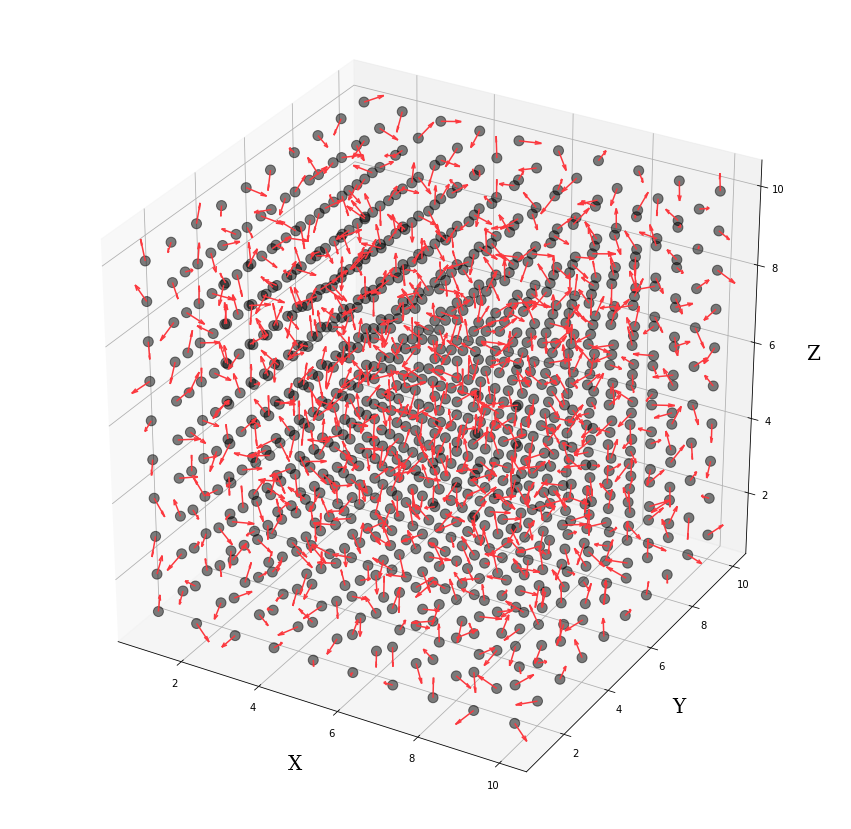

In [5]:
# ============= PLOTTING INITIAL CONFIGURATION =============
#Normal 3D plot
%matplotlib inline 
#Interactive 3D plot
#%matplotlib qt 

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfXyz.x, dfXyz.y, dfXyz.z, s=100, alpha=0.5, color="k")
ax.quiver(dfXyz.x, dfXyz.y, dfXyz.z,dfMag.x, dfMag.y, dfMag.z, length=0.5, color='#FC383E')
#ax.set_title('3D - Representation', size="xx-large", family="serif", weight= "semibold")
ax.set_xlabel('X',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_ylabel('Y',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_zlabel('Z',fontsize= 20, color="#000000", family="serif", labelpad=20)
#plt.savefig('3d.png')
plt.show()

In [6]:
# SETTING magTotal
magTotal = magTotalSet(mag, vecH,n)
# FILLING DATAFRAME AND ARRAY
df = pd.DataFrame([
    [Hext, magTotal]
], columns = ["Hext", "MagTotal"])

In [7]:
# ============= DYNAMIC TEMPERATURE (STEP = 100K) ============= 
angle = 30
while angle<181:
    
    temp = 20
    while temp < 301:

        #RESTARTING DYNAMIC VARIABLES
        Hext = 0.00
        magTotal = 0.00
        mag = np.empty(shape=(int(n),3))
        for i in range(0,n):
            mag[i] = initConf[i]
        #dfMag = pd.DataFrame(data=mag[0:,0:],columns=['x','y','z']) 
        #NAMING NEW FILE
        filename = "theta" + str(angle) + "/temp" + str(temp)
        dThet = angle*pi/180.0
        #RECREATING ARRAY FOR M(H) DATA
        mhCurve = np.empty(shape=(nHext+1,2))
        mhCurve[0,0] = Hext
        mhCurve[0,1] = magTotal
        with open(filename, "w"):
            pass
        # SETTING magTotal AND DATAFRAME USING MARKOV CHAINS
        for i in range(0,nHext):    
            Hext = HextCalc(Hext,nHstep,Hmax,i)   
            for step in range(0,int(mcs)):
                for nanoparticle in range(0,int(n)):
                    randN = round(np.random.rand()*(n-1)) #Random Nanoparticle
                    mag[randN] = abc(vecH, Hext, dThet, ku[randN], pi, mag[randN], d, kuni, Ms, kb, temp)   

            # FILLING FILE magData.txt FOR 3D-PLOT
            # with open("magData.txt","wb") as file:
                # np.savetxt(file,mag,delimiter="\t")      

            magTotal = magTotalSet(mag, vecH,n)   
            print(i,Hext,magTotal)
            df.loc[i+1]=[Hext,magTotal]
            # FILLING FILE mhData.txt
            mhCurve[i+1,0] = Hext
            mhCurve[i+1,1] = magTotal
            with open(filename,'wb') as file:
                np.savetxt(file,mhCurve,delimiter="\t")
                
        if temp<100:
            temp = temp+20
        else: 
            temp = temp+50
                
    angle = angle + 30

0 0.01 39.313755263940905
1 0.02 47.37010177013706
2 0.03 53.54989356630378
3 0.04 62.108508907232164
4 0.05 68.39141833183923
5 0.060000000000000005 72.47637724800195
6 0.07 85.17498020873315
7 0.08 92.39441868229663
8 0.09 101.67878076333986
9 0.09999999999999999 108.67797812404967
10 0.10999999999999999 119.72741213323525
11 0.11999999999999998 123.17729618833563
12 0.12999999999999998 130.64914999046798
13 0.13999999999999999 141.16244628802082
14 0.15 148.6610180987786
15 0.16 157.3503813573033
16 0.17 163.46429951469258
17 0.18000000000000002 172.49656955663477
18 0.19000000000000003 180.84809316131143
19 0.20000000000000004 190.7103905342464
20 0.21000000000000005 200.05086587018812
21 0.22000000000000006 209.67484473509504
22 0.23000000000000007 218.94398016225605
23 0.24000000000000007 226.84745748388656
24 0.25000000000000006 238.8140558197793
25 0.26000000000000006 249.32902571620062
26 0.2700000000000001 261.8964542582161
27 0.2800000000000001 282.32005930979824
28 0.290000

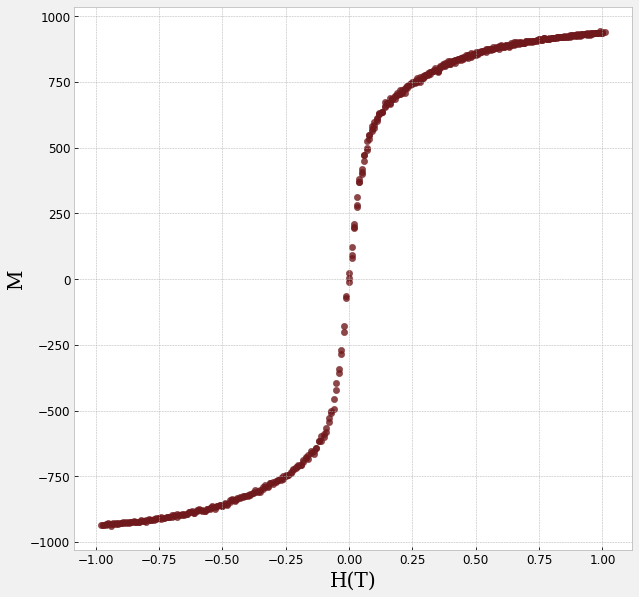

In [8]:
# PLOTTING HYSTERESIS LOOP
plt.style.use("bmh")
ax = df.plot.scatter(x='Hext',y='MagTotal',alpha=0.8, figsize=(10,10), fontsize=12, s=40, color='#70191C')
#ax.set_title('Curva M(H)', size="xx-large", family="serif", weight= "semibold")
ax.set_facecolor('#FFFFFF')
plt.gcf().set_facecolor('#f1f1f1')
plt.xlabel('H(T)', fontsize= 20, color="#000000", family="serif")
plt.ylabel('M', fontsize= 20, color="#000000", family="serif")
plt.savefig('hist.jpg')
plt.show()

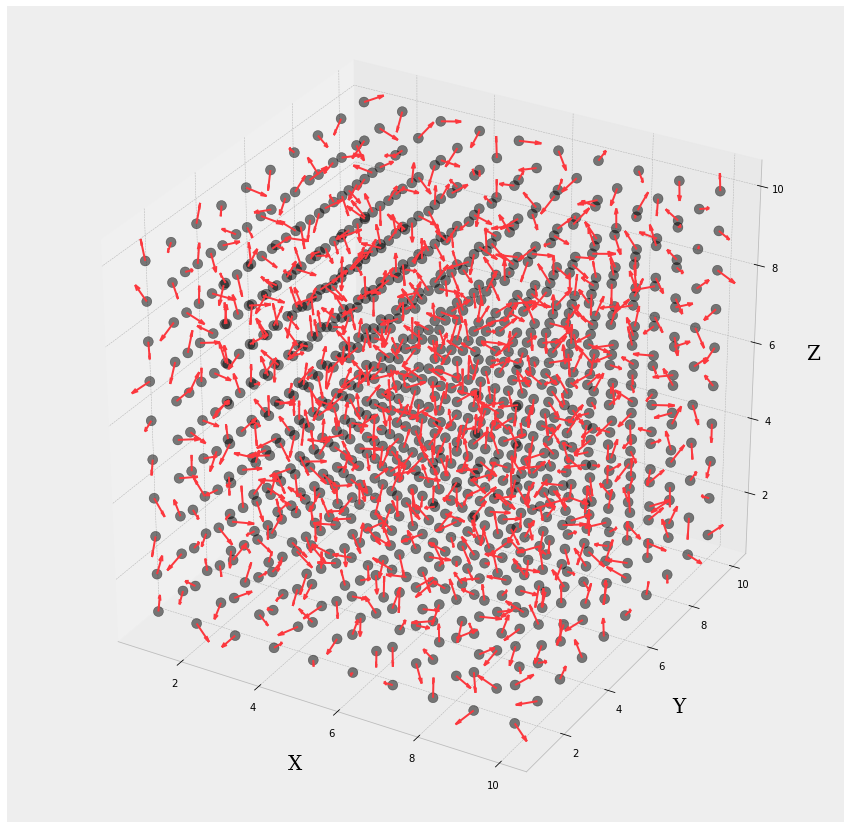

In [9]:
# ============= PLOTTING INITIAL CONFIGURATION =============
#Normal 3D plot
%matplotlib inline 
#Interactive 3D plot
#%matplotlib qt 

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfXyz.x, dfXyz.y, dfXyz.z, s=100, alpha=0.5, color="k")
ax.quiver(dfXyz.x, dfXyz.y, dfXyz.z,dfMag.x, dfMag.y, dfMag.z, length=0.5, color='#FC383E')
#ax.set_title('3D - Representation', size="xx-large", family="serif", weight= "semibold")
ax.set_xlabel('X',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_ylabel('Y',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_zlabel('Z',fontsize= 20, color="#000000", family="serif", labelpad=20)
plt.savefig('3d.png')
plt.show()